In [15]:
%matplotlib inline
from simulation import *
from math import *
import numpy as np

wavelength = 1
NA = 1
pitch = 15
# dx = 0.1
dx = 0.25
dbu = 1e-6
size = int(ceil(pitch / dx))
grid_info_2d = grid_info_2d_s.create_grid_info_bloch_mode([size, size], wavelength, 0.0, NA, [[-pitch/2, -pitch/2], [pitch/2, pitch/2]], dbu)
xsize, ysize = grid_info_2d.tilesize


In [16]:
print(grid_info_2d)

* grid info                             
------------------------------------------
tilesize      :  [60,60]                
spatial start :  [-7.5,-7.5]            
spatial step  :  [0.25,0.25]            
fourier start :  [0,0]                  
fourier step  :  [0.0666667,0.0666667]  
coords place  :  |*--|corner            



In [17]:
def to_dbu(n):
    return int(n/dbu)
def from_dbu(n):
    return n *dbu

mat_metal = material_eps(); 
mat_metal.name = "Metal"
mat_metal.set_scalar(1+0j)
mat_air = material_eps(); 
mat_air.name = "Air"
mat_air.set_scalar(0+0j)

pattern = geometry_pattern()
pattern.pBackground = mat_air
pattern.dbu = dbu
pattern.name = "test"

s1 = shape(); 
s1.pMaterial = mat_metal
s1.center = [to_dbu(0), to_dbu(0)]; 


In [18]:
# poly definition

p0,      ctrl1, p1     = [to_dbu(0), to_dbu(0)], [to_dbu(2), to_dbu(-1)], [to_dbu(4), to_dbu(0)]
p1_end,  ctrl2, p2     =                     p1, [to_dbu(6), to_dbu(3)],  [to_dbu(4), to_dbu(6)]
p2_end,  ctrl3, p0_end =                     p2, [to_dbu(2), to_dbu(5)],  p0

area=19.999999655935998


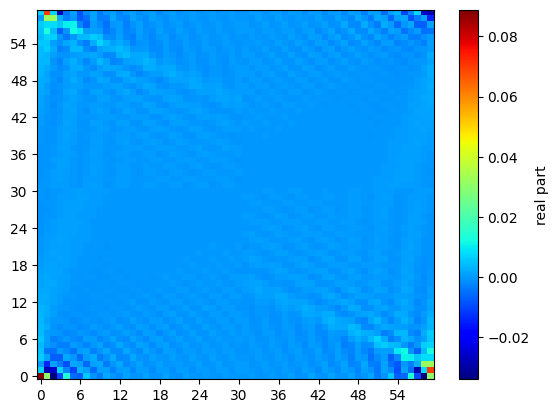

circle DC=(0.08888889104127884+0j)


In [19]:
c1 = bezier_poly_2()
# c1.control_points.extend([p0, ctrl1, p1], [p1, ctrl2, p2], [p2, ctrl3, p0])
c1.control_points.append([p0, ctrl1, p1])
c1.control_points.append([p1, ctrl2, p2])
c1.control_points.append([p2, ctrl3, p0])
s1.data = c1
print(f"area={s1.area()*dbu*dbu}")
pattern.shapes.extend([s1])
pattern.parent.extend([-1])

fft_bezier = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_bezier)
print(f"circle DC={fft_bezier[0]}")

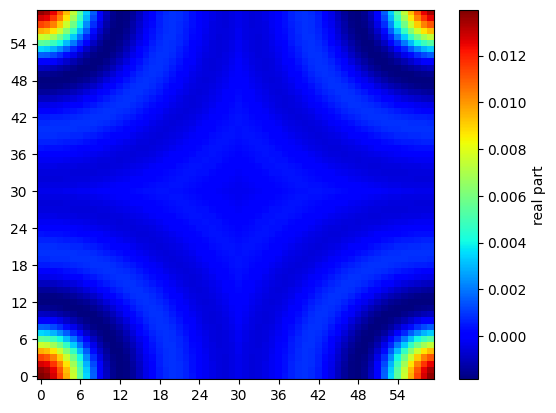

circle DC=(0.013962634839117527+0j), should be : 0.05235987797333332


In [20]:
c1 = circle(); c1.radius = to_dbu(1)
s1.data = c1

pattern.shapes[:] = s1

fft_circle = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_circle)
print(f"circle DC={fft_circle[0]}, should be : {c1.area() * dbu * dbu/np.sqrt(len(fft_circle))}")

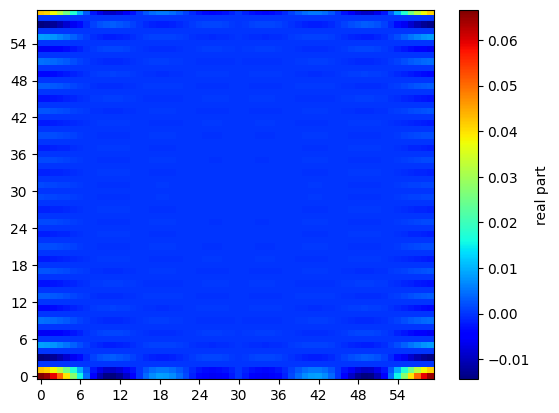

circle DC=(0.06666667014360428+0j), should be : 0.25000000443733333


In [21]:
c1 = rect(); c1.halfwidth = [to_dbu(1), to_dbu(pitch/4)]
s1.data = c1
pattern.shapes[:] = s1

fft_rect = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_rect)
print(f"circle DC={fft_rect[0]}, should be : {c1.area() * dbu * dbu/np.sqrt(len(fft_rect))}")

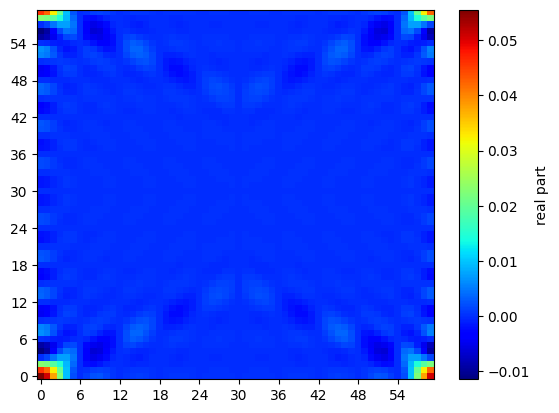

triangle DC=(0.0555555559694767+0j)
circle DC=(0.0555555559694767+0j), should be : 0.2083333341184


In [22]:
c1 = poly(); c1.vertices.extend([[to_dbu(-2.5), to_dbu(-2.5)],[to_dbu(2.5), to_dbu(-2.5)],[0, to_dbu(2.5)]])
s1.data = c1

pattern.shapes[:] = s1

fft_tri = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_tri)
print(f"triangle DC={fft_tri[0]}")
print(f"circle DC={fft_tri[0]}, should be : {c1.area() * dbu * dbu/np.sqrt(len(fft_tri))}")

In [23]:
def get_raster(input):
    raster = xsize * ysize *np.real(np.fft.fftshift(np.fft.ifft2(np.array(input).reshape(*grid_info_2d.tilesize)).astype(np.complex64)))
    return raster.flatten().tolist()

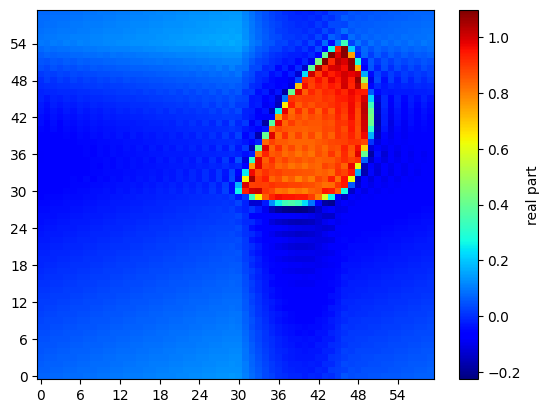

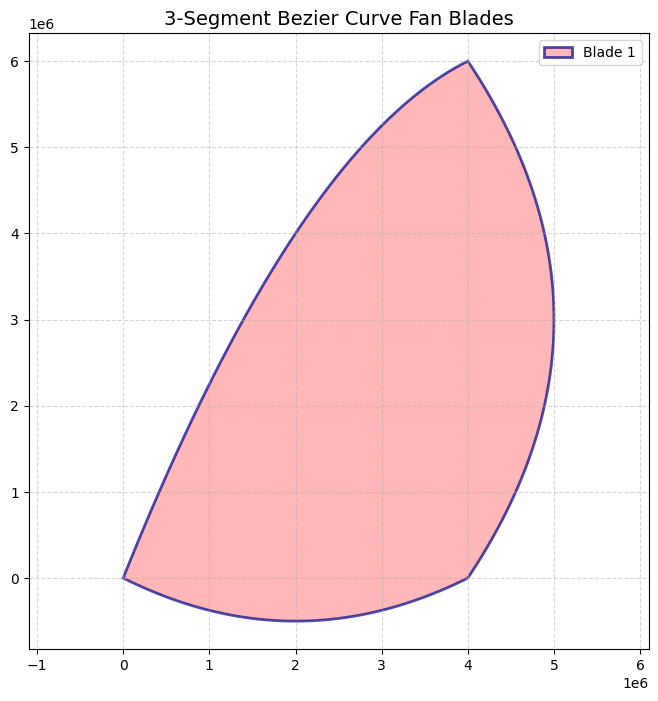

In [24]:
grid_info_2d.display(get_raster(fft_bezier))


import numpy as np
import matplotlib.pyplot as plt

def bezier_quadratic(p0, p1, p2, num=100):
    """计算二阶贝塞尔曲线的点"""
    p0, p1, p2 = np.array(p0), np.array(p1), np.array(p2)
    t = np.linspace(0, 1, num).reshape(-1, 1)
    # 向量化计算：(1-t)^2*P0 + 2(1-t)*t*P1 + t^2*P2
    curve = (1-t)**2 * p0 + 2*(1-t)*t * p1 + t**2 * p2
    return curve

def get_leaf_points(angle_deg):
    """生成三段式扇叶，并根据角度旋转"""
    rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(rad), np.sin(rad)
    R = np.array([[cos_a, -sin_a], [sin_a, cos_a]])


    # 计算三段曲线
    c1 = bezier_quadratic(p0,      ctrl1, p1)
    c2 = bezier_quadratic(p1,  ctrl2, p2)
    c3 = bezier_quadratic(p2,  ctrl3, p0)
    
    # 合并所有点 (去除重复的连接点以保持平滑)
    leaf = np.vstack([c1, c2[1:], c3[1:]])
    
    # 应用旋转矩阵
    return leaf @ R.T

# --- 绘图设置 ---
plt.figure(figsize=(8, 8))
angles = [0]#[0, 90, 180, 270] # 四个叶片
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

for i, angle in enumerate(angles):
    leaf_pts = get_leaf_points(angle)
    # 填充面
    plt.fill(leaf_pts[:, 0], leaf_pts[:, 1], color=colors[i], 
             alpha=0.7, edgecolor='darkblue', lw=2, label=f'Blade {i+1}')

# 界面优化
plt.title("3-Segment Bezier Curve Fan Blades", fontsize=14)
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

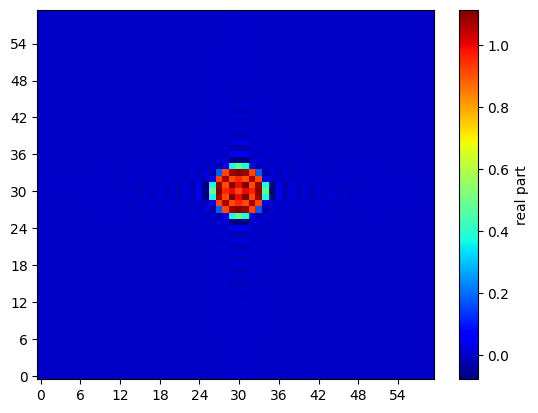

In [25]:
grid_info_2d.display(get_raster(fft_circle))

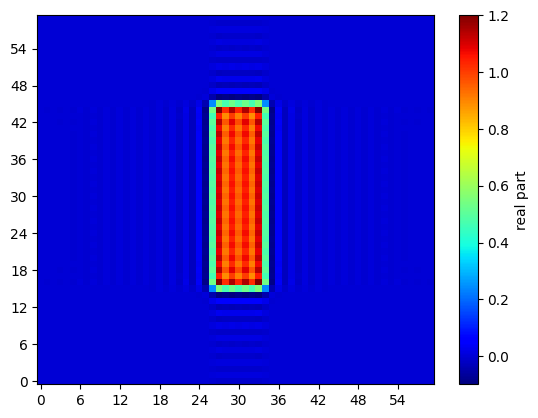

In [26]:
grid_info_2d.display(get_raster(fft_rect))

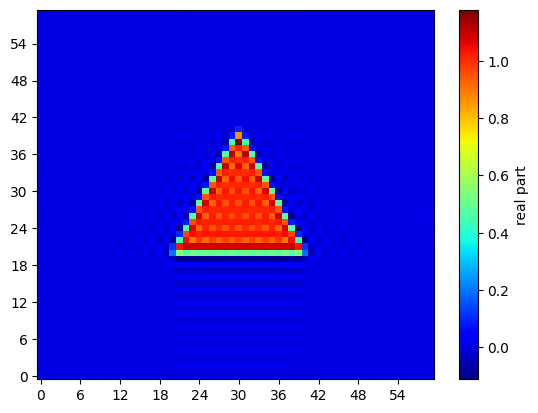

In [27]:
grid_info_2d.display(get_raster(fft_tri))

In [28]:
import numpy as np
from scipy.integrate import quad
from scipy.special import comb

def ground_truth_fresnel(W, V, U):
    """基准参考：使用 scipy 的高精度数值积分"""
    def real_part(t):
        phi = 2 * np.pi * (W * t**2 + V * t + U)
        return np.cos(phi)
    
    def imag_part(t):
        phi = 2 * np.pi * (W * t**2 + V * t + U)
        return -np.sin(phi)

    re, _ = quad(real_part, 0, 1, limit=200)
    im, _ = quad(imag_part, 0, 1, limit=200)
    return complex(re, im)

def taylor_fresnel(W, V, U, order=16):
    """你之前的泰勒级数实现（在大参数下会失去精度）"""
    sum_total = 0j
    phase_const = np.exp(-2j * np.pi * U)
    neg_j_2pi = -2j * np.pi
    
    term_n = 1.0 + 0j
    for n in range(order + 1):
        if n > 0:
            term_n *= (neg_j_2pi / n)
            
        inner_sum = 0
        for m in range(n + 1):
            # C(n, m) * W^m * V^(n-m) / (n + m + 1)
            val_m = comb(n, m) * (W**m) * (V**(n-m))
            inner_sum += val_m / (n + m + 1)
            
        sum_total += term_n * inner_sum
    return sum_total * phase_const

def gauss_fresnel_5pt(W, V, U):
    """翻译自你的 C++ 高斯-勒让德 5 点积分代码"""
    nodes = [
        0.0469100770306680, 0.2307653449471585, 0.5, 
        0.7692346550528415, 0.9530899229693320
    ]
    weights = [
        0.1184634425280945, 0.2393143352496832, 0.2844444444444444, 
        0.2393143352496832, 0.1184634425280945
    ]
    
    result = 0j
    for i in range(5):
        t = nodes[i]
        phi = 2 * np.pi * (W * t**2 + V * t + U)
        # cT(cos, -sin)
        result += complex(np.cos(phi), -np.sin(phi)) * weights[i]
    return result

# --- 测试与比较 ---

# 1. 小参数场景 (Taylor 表现良好)
print("--- 场景 A: 小相位 (W=0.1, V=0.2, U=0.05) ---")
W, V, U = 0.1, 0.2, 0.05
ref = ground_truth_fresnel(W, V, U)
tay = taylor_fresnel(W, V, U, order=16)
gau = gauss_fresnel_5pt(W, V, U)
print(f"Reference: {ref}")
print(f"Taylor   : {tay} (Error: {abs(tay-ref):.2e})")
print(f"Gauss 5pt: {gau} (Error: {abs(gau-ref):.2e})")

# 2. 大参数场景 (Taylor 崩溃)
print("\n--- 场景 B: 高频相位 (W=5.0, V=2.0, U=0.0) ---")
W, V, U = 5.0, 2.0, 0.0
ref = ground_truth_fresnel(W, V, U)
tay = taylor_fresnel(W, V, U, order=16)
gau = gauss_fresnel_5pt(W, V, U)
print(f"Reference: {ref}")
print(f"Taylor   : {tay} (Error: {abs(tay-ref):.2e}) <-- 精度丢失严重")
print(f"Gauss 5pt: {gau} (Error: {abs(gau-ref):.2e}) <-- 依然稳定")

--- 场景 A: 小相位 (W=0.1, V=0.2, U=0.05) ---
Reference: (0.35411078336087837-0.7810312936915652j)
Taylor   : (0.35411078336316615-0.7810312936863439j) (Error: 5.70e-12)
Gauss 5pt: (0.3541107593391923-0.7810313022712585j) (Error: 2.55e-08)

--- 场景 B: 高频相位 (W=5.0, V=2.0, U=0.0) ---
Reference: (0.01687452083607872-0.054140866225438435j)
Taylor   : (289012082020.766+113623524558.01082j) (Error: 3.11e+11) <-- 精度丢失严重
Gauss 5pt: (-0.2910869867279145-0.1623128058005156j) (Error: 3.26e-01) <-- 依然稳定
